# Расчет максимальной награды

In [6]:
# # максимум при данных условиях - 113
# # размер поля
# ROW = 6
# COL = 6
# # количество в ряд
# TOWIN = 5
# # максимальное количество значений в ряд 
# maxSteps = ROW*COL
# # награда за победу
# reward = ROW*COL
# # минимальное значение stepsToWin - первый ход победителя, 
# # до достижения TOWIN
# stepsToWin = 2*TOWIN-1
# # rewardSteps - чем быстрее достигнута победа, тем больше это значение
# rewardSteps = maxSteps - stepsToWin
# CORRECTSTEPREWARD = 50
# # максимальное значение choisereward - количество TOWIN*CORRECTSTEPREWARD
# choisereward = TOWIN*CORRECTSTEPREWARD
# # максимально возможная награда

# rewardPerGame = reward + rewardSteps + choisereward
# print(rewardPerGame*GAMESCOUNT)

In [7]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
############################################################################################################
#Implementation of Two Player Tic-Tac-Toe game in Python.
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from pygad import torchga
import pygad

import numpy as np
from numpy import dtype
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten

In [33]:
############################################################################################################
# константы
# размер доски
ROW = 6
COL = 6
# количество фишек подряд для выигрыша
TOWIN = 5
# количество игр для статистики и усреднения результов
GAMESCOUNT = 1
# награда за корректный ход: выставление фишки на НЕЗАНЯТОЕ поле
CORRECTSTEPREWARD = 50

In [9]:
import numpy as np

#----------------------------------------------------------------------------------------------------------#
class Board():
    # класс доски
    def __init__(self, row=3, col=3):
        self.board = np.full([row, col], 0)
        
    def clear_board(self):
        self.board = np.full_like(self.board, 0)

In [10]:
#----------------------------------------------------------------------------------------------------------#
# нейросеть с использованием keras
class BrainKeras():
    # класс нейросети
    def __init__(self):
        # создаем модель
        self.model = keras.Sequential([
            Flatten(input_shape=(ROW*COL, 1), name='input_layer'),
            Dense(ROW*COL*4, activation='relu', name='hidden_layer_1'),
            Dense(ROW*COL*4, activation='relu', name='hidden_layer_2'),
            Dense(ROW*COL, activation='softmax', name='output_layer')
        ])
        # вывод структуры НС в консоль
        # print(model.summary())
        my_optim_Adam = keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(optimizer=my_optim_Adam,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    def saveNN(self):
        self.model.save('nonTrainedModelBrain.h5')
        print('model saved')
    
    def loadNN(self, path):
        self.model = keras.models.load_model(path)
        print('model loaded')

In [11]:
#----------------------------------------------------------------------------------------------------------#
# нейросеть с использованием pytorch
import os
import torch
from torch import nn

class BrainPytorch(nn.Module):
    # класс нейросети
    def __init__(self):
        # создаем модель
        super(BrainPytorch, self).__init__()
        # self.input = nn.Linear(ROW*COL, ROW*COL*4)
        # self.hidden_layer_1 = nn.Linear(ROW*COL*4, ROW*COL*4)
        # self.hidden_layer_2 = nn.Linear(ROW*COL*4, ROW*COL)
        # self.output = nn.Linear(ROW*COL, ROW*COL)
        
        self.model = nn.Sequential(
            nn.Linear(ROW*COL, ROW*COL*10),
            nn.ReLU(),
            nn.Linear(ROW*COL*10, ROW*COL*6),
            nn.ReLU(),
            nn.Linear(ROW*COL*6, ROW*COL*5),
            nn.ReLU(),
            nn.Linear(ROW*COL*5, ROW*COL*5),
            nn.ReLU(),
            nn.Linear(ROW*COL*5, ROW*COL*3),
            nn.ReLU(),
            nn.Linear(ROW*COL*3, ROW*COL),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def saveNN(self):
        # Save model
        torch.save(self.model, 'nonTrainedModelBrain.pt')
        print('model saved')
    
    def loadNN(self, path):
        # Load model
        self.model = torch.load(path)
        self.model.eval()
        print('model loaded')

In [42]:
#----------------------------------------------------------------------------------------------------------#        
class PlayerXNNTorch():
    # класс игрока
    def __init__(self):
        self.brain = BrainPytorch()
        self.rewardPerGame = []
        self.total_reward = 0
        self.choisereward = 0
    
    def move(self, board):
        '''
        определяем ход игрока
        '''
        data_inputs = board.reshape(1, -1)
        data_inputs = torch.from_numpy(data_inputs).float()
        predictions = self.brain(data_inputs)
        data_outputs = predictions.detach().numpy()
        data_outputs = data_outputs.reshape(ROW, COL)
        moveRow, moveCol = np.unravel_index(np.argmax(data_outputs), data_outputs.shape)
        if board[moveRow, moveCol] == 0:
            self.choisereward += CORRECTSTEPREWARD
        return moveRow, moveCol

In [13]:
#----------------------------------------------------------------------------------------------------------#        
class PlayerXNNKeras():
    # класс игрока
    def __init__(self):
        self.brain = BrainKeras()
        self.rewardPerGame = []
        self.total_reward = 0
        self.choisereward = 0

    def move(self, board):
        '''
        определяем ход игрока
        '''
        data_inputs = board.reshape(-1, 1)
        data_inputs = np.expand_dims(data_inputs, axis=0)
        predictions = self.brain.model.predict(data_inputs)
        predictions = predictions.reshape(ROW, COL)
        moveRow, moveCol = np.unravel_index(np.argmax(predictions), predictions.shape)
        if board[moveRow, moveCol] == 1 or board[moveRow, moveCol] == -1:
            self.choisereward += -1
        else:
            self.choisereward += 1
        # while board[moveRow, moveCol] == 1 or board[moveRow, moveCol] == -1:
        #     moveRow, moveCol = np.unravel_index(np.argmax(predictions), predictions.shape)
        #     predictions[moveRow, moveCol] = -10
        #     self.reward += -1
        return moveRow, moveCol



In [14]:
#----------------------------------------------------------------------------------------------------------#
class PlayerO():
    # класс игрока
    def move(self, board):
        '''
        определяем ход игрока
        '''
        moveRow = np.random.randint(len(board[:, 0]))
        moveCol = np.random.randint(len(board[0, :]))
        while board[moveRow, moveCol] == 1 or board[moveRow, moveCol] == -1:
            moveRow = np.random.randint(len(board[:, 0]))
            moveCol = np.random.randint(len(board[0, :]))
        return moveRow, moveCol



In [15]:
#----------------------------------------------------------------------------------------------------------#
def game(b, t, pl1, pl2, winn):
    # устанавливаем, чей ход первый
    turn = t
    # создаем экземпляры игроков
    playerX = pl1
    playerO = pl2
    winner = winn
    # maxSteps = mSteps
    winnersLine = ''
    # основной цикл
    for i in range(ROW*COL):
        # print('step: ', i+1)
        if turn == 1:
            # X move
            moveRow, moveCol = playerX.move(b.board)
            # print('turn:', turn, moveRow, moveCol)
            b.board[moveRow, moveCol] = 1
            turn = -1
        else:
            # O move
            moveRow, moveCol = playerO.move(b.board)
            # print('turn:', turn, moveRow, moveCol)
            b.board[moveRow, moveCol] = -1
            turn = 1

        
        # проверка победителя по строкам
        for row in range(ROW):
            TOWINX = np.where(b.board[row, :] == 1)[0]
            TOWINO = np.where(b.board[row, :] == -1)[0]
            if TOWINX.size > 0 and len(TOWINX) == TOWIN and TOWINX[-1] - TOWINX[0] == TOWIN-1 and winner == 0:
                winner = 'X wins!'
                winnersLine = 'gorizontal: ' + str(b.board[row, :])
            if TOWINO.size > 0 and len(TOWINO) == TOWIN and TOWINO[-1] - TOWINO[0] == TOWIN-1 and winner == 0:
                winner = 'O wins!'
                winnersLine = 'gorizontal: ' + str(b.board[row, :])

        # проверка победителя по столбцам
        for col in range(COL):
            # slises = np.insert(slises, row, [[b.board[row, :]]], axis=0)
            # slises = np.append(slises, [[b.board[row, :]]])
            TOWINX = np.where(b.board[:, col] == 1)[0]
            TOWINO = np.where(b.board[:, col] == -1)[0]
            if TOWINX.size > 0 and len(TOWINX) == TOWIN and TOWINX[-1] - TOWINX[0] == TOWIN-1 and winner == 0:
                winner = 'X wins!'
                winnersLine = 'vertical: ' + str(b.board[:, col])
            if TOWINO.size > 0 and len(TOWINO) == TOWIN and TOWINO[-1] - TOWINO[0] == TOWIN-1 and winner == 0:
                winner = 'O wins!'
                winnersLine = 'vertical: ' + str(b.board[:, col])

        # проверка победителя по диагоналям
        # https://coderoad.ru/6313308/%D0%9F%D0%BE%D0%BB%D1%83%D1%87%D0%B8%D1%82%D1%8C-%D0%B2%D1%81%D0%B5-%D0%B4%D0%B8%D0%B0%D0%B3%D0%BE%D0%BD%D0%B0%D0%BB%D0%B8-%D0%B2-%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B5-%D1%81%D0%BF%D0%B8%D1%81%D0%BA%D0%B5-%D1%81%D0%BF%D0%B8%D1%81%D0%BA%D0%BE%D0%B2-%D0%B2-Python
        diags = [b.board[::-1,:].diagonal(i) for i in range(-b.board.shape[0]+1, b.board.shape[1])]
        diags.extend(b.board.diagonal(i) for i in range(b.board.shape[1]-1, -b.board.shape[0],-1))
        diagonalList = ([n.tolist() for n in diags])
        # print(diagonalList)
        for d in (diagonalList):
            d = np.array(d)
            TOWINX = np.where(d == 1)[0]
            TOWINO = np.where(d == -1)[0]
            if TOWINX.size > 0 and len(TOWINX) == TOWIN and TOWINX[-1] - TOWINX[0] == TOWIN-1 and winner == 0:
                winner = 'X wins!'
                winnersLine = 'diagonal: ' + str(d)
            if TOWINO.size > 0 and len(TOWINO) == TOWIN and TOWINO[-1] - TOWINO[0] == TOWIN-1 and winner == 0:
                winner = 'O wins!'
                winnersLine = 'diagonal: ' + str(d)
        
        # render(winner, winnersLine, b, r=True)
        # если определился победитель - прерываем цикл
        if winner != 0:
            break

    return winner, winnersLine, i+1



In [16]:
#----------------------------------------------------------------------------------------------------------#
def render(w, wLine, b, step, r=True):
    if r:
        print(b.board)
        print(wLine)
        print('winner: ', w)
        print('steps: ', step)
        print('---------------------')



In [64]:
#----------------------------------------------------------------------------------------------------------#
def game_statistics(b):
    # создаем экземпляры игроков
    playerX = PlayerXNNTorch()
    playerX.brain.loadNN('/home/ol/eclipse-workspace/tic_tac_toe/primaryBrain.pt')

    playerO = PlayerO()
    # playerO = PlayerXNNTorch()
    # playerO.brain.loadNN('/home/ol/eclipse-workspace/tic_tac_toe/primaryBrain.pt')

    winner = 0
    maxSteps = ROW*COL
    # бонус за победу
    reward = ROW*COL
    # statistics
    winsXCount = 0
    drawsXCount = 0
    loseXCount = 0
    # rendering
    r = True
    # основной цикл
    for g in range(GAMESCOUNT):
        # устанавливаем, чей ход первый
        turn = np.random.choice([-1, 1])

        w, wLine, stepsToWin = game(b, turn, playerX, playerO, winner)
        if w == 'X wins!':
            render(w, wLine, b, stepsToWin, r)
            winsXCount += 1
            rewardSteps = maxSteps - stepsToWin
            playerX.rewardPerGame.append(reward + rewardSteps + playerX.choisereward)

            
        elif w == 0:
            render(w, wLine, b, stepsToWin, r)
            drawsXCount += 1
            rewardSteps = maxSteps - stepsToWin
            # playerX.rewardPerGame.append(rewardSteps + playerX.choisereward//2)
            playerX.rewardPerGame.append(0)#(rewardSteps + playerX.choisereward//2)
            
        elif w == 'O wins!':
            render(w, wLine, b, stepsToWin, r)
            loseXCount += 1
            rewardSteps = maxSteps - stepsToWin
            playerX.rewardPerGame.append(0)#-(reward + rewardSteps + playerX.choisereward))

        b.clear_board()
        playerX.choisereward = 0
    print(playerX.rewardPerGame)
    playerX.total_reward  = np.mean(playerX.rewardPerGame)
    # статистика
    print('Total games: ', GAMESCOUNT)
    print('X wins in:   ', int(winsXCount/GAMESCOUNT*100), '%')
    print('X lose in:   ', int(loseXCount/GAMESCOUNT*100), '%')
    print('X draws in:  ', int(drawsXCount/GAMESCOUNT*100), '%')
    print('X mean reward:  ', str(playerX.total_reward))
    
    # playerX.brain.saveNN()

In [66]:
# main
#----------------------------------------------------------------------------------------------------------#
if __name__ == "__main__":
    # делаем экземпляр доски
    b = Board(ROW, COL)
    # запускаем игру, передаем доску
    game_statistics(b)
  
############################################################################################################


model loaded
[[ 0  0  0  0  0  0]
 [ 0  1  0  0  0 -1]
 [-1  0  1  0  0  0]
 [ 0 -1  0  1  0  0]
 [ 0  0 -1  0  1  0]
 [ 0  0 -1  0  0  1]]
diagonal: [0 1 1 1 1 1]
winner:  X wins!
steps:  11
---------------------
[311]
Total games:  1
X wins in:    100 %
X lose in:    0 %
X draws in:   0 %
X mean reward:   311.0


In [ ]:
import torch
from pygad import torchga
import pygad

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function

    predictions = pygad.torchga.predict(model=model,
                                        solution=solution,
                                        data=data_inputs)

    abs_error = loss_function(predictions, data_outputs).detach().numpy() + 0.00000001

    solution_fitness = 1.0 / abs_error

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

# Create the PyTorch model.
input_layer = torch.nn.Linear(3, 5)
relu_layer = torch.nn.ReLU()
output_layer = torch.nn.Linear(5, 1)

model = torch.nn.Sequential(input_layer,
                            relu_layer,
                            output_layer)
# print(model)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=10)

loss_function = torch.nn.L1Loss()

# Data inputs
data_inputs = torch.tensor([[0.02, 0.1, 0.15],
                            [0.7, 0.6, 0.8],
                            [1.5, 1.2, 1.7],
                            [3.2, 2.9, 3.1]])

# Data outputs
data_outputs = torch.tensor([[0.1],
                             [0.6],
                             [1.3],
                             [2.5]])

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 250 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Make predictions based on the best solution.
predictions = pygad.torchga.predict(model=model,
                                    solution=solution,
                                    data=data_inputs)
print("Predictions : \n", predictions.detach().numpy())

abs_error = loss_function(predictions, data_outputs)
print("Absolute Error : ", abs_error.detach().numpy())

In [20]:
def fitness_func(solution, sol_idx):
    # запускаем игру для определения среднего значения 
    # пригодности одного из решений

    global b, torch_ga
    # создаем экземпляры игроков
    playerX = PlayerXNNTorch()
    
    playerO = PlayerO()
    winner = 0
    maxSteps = ROW*COL
    reward = ROW*COL
    # statistics
    winsXCount = 0
    drawsXCount = 0
    loseXCount = 0
    # rendering
    r = False

    model_weights_matrix = pygad.torchga.model_weights_as_dict(model=playerX.brain,
                                                               weights_vector=solution)
    playerX.brain.load_state_dict(model_weights_matrix)

    # основной цикл
    for g in range(GAMESCOUNT):
        # устанавливаем, чей ход первый
        turn = np.random.choice([-1, 1])

        w, wLine, stepsToWin = game(b, turn, playerX, playerO, winner)
        if w == 'X wins!':
            render(w, wLine, b, stepsToWin, r)
            winsXCount += 1
            rewardSteps = maxSteps - stepsToWin
            playerX.rewardPerGame.append(reward + rewardSteps + playerX.choisereward)

            
        elif w == 0:
            render(w, wLine, b, stepsToWin, r)
            drawsXCount += 1
            rewardSteps = maxSteps - stepsToWin
            playerX.rewardPerGame.append(0)#(rewardSteps + playerX.choisereward//2)

            
        elif w == 'O wins!':
            render(w, wLine, b, stepsToWin, r)
            loseXCount += 1
            rewardSteps = maxSteps - stepsToWin
            playerX.rewardPerGame.append(0)#-(reward + rewardSteps + playerX.choisereward))

        b.clear_board()
        playerX.choisereward = 0

    playerX.total_reward  = np.sum(playerX.rewardPerGame)#np.mean(playerX.rewardPerGame)
    return playerX.total_reward

In [21]:
def callback_generation(ga_instance):
    global loaded
    if ga_instance.generations_completed % 10 == 0:
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("MaxFitness    = {fitness}".format(fitness=np.amax(ga_instance.best_solutions_fitness)))
        # выводим график обучения
        ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)
        # сохраняем лучшую модель
        name = '/home/ol/eclipse-workspace/tic_tac_toe/saved_ga_instance_gen_' + str(ga_instance.generations_completed)
        ga_instance.save(filename=name)
        loaded = ga_instance
    else:
        print("Generation = {generation}".format(generation=ga_instance.generations_completed))
        print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [ ]:
# loaded.save(filename='/home/ol/eclipse-workspace/tic_tac_toe/saved_ga_instance_gen_2000')

In [22]:
from pygad import torchga
import pygad

#----------------------------------------------------------------------------------------------------------#
def game_statistics_GA(b):
    # создаем экземпляры игроков
    primaryBrain = PlayerXNNTorch()
    
    # определяем экземпляр класса гентического алгоритма
    torch_ga = torchga.TorchGA(model=primaryBrain.brain, num_solutions=100)
    # ga_instance = loaded
    num_generations = 5000  # Number of generations.
    num_parents_mating = 40 # Number of solutions to be selected as parents in the mating pool.
    initial_population = torch_ga.population_weights # Initial population of network weights

    # создаем экземпляр pygad.GA класса
    # ga_instance = pygad.GA(num_generations=num_generations,
    #                         num_parents_mating=num_parents_mating,
    #                         initial_population=initial_population,
    #                         fitness_func=fitness_func,
    #                         on_generation=callback_generation)
    # создаем экземпляр pygad.GA класса
    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            initial_population=initial_population,
                            # save_solutions=True,
                            save_best_solutions=True,
                            # keep_parents=num_parents_mating//2,
                            parent_selection_type="rank",
                            crossover_type="single_point",
                            mutation_type="adaptive",
                            mutation_probability = [0.75, 0.1],
                            fitness_func=fitness_func,
                            on_generation=callback_generation)
    ga_instance.run()
    print('finished')
    # After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
    ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

    # Returning the details of the best solution.
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

    # сохраняем лучшую модель]
    model_weights_matrix = pygad.torchga.model_weights_as_dict(model=primaryBrain.brain,
                                                               weights_vector=solution)
    primaryBrain.brain.load_state_dict(model_weights_matrix)
    torch.save(primaryBrain.brain, '/home/ol/eclipse-workspace/tic_tac_toe/primaryBrain.pt')


In [ ]:
# loaded = pygad.load(filename='saved_ga_instance_gen_340')
# print(loaded.best_solutions_fitness)
# print(np.amax(loaded.best_solutions_fitness))
# index_best = np.where(loaded.best_solutions_fitness == np.amax(loaded.best_solutions_fitness))
# print(index_best)

In [ ]:
# # для выборочного сохранения моделей
# # print(loaded.solution()[0])
# # print(loaded.__dict__)
# # print(len(loaded.best_solutions))
# # solution, solution_fitness, solution_idx = loaded.best_solution()
# # for num, sol in enumerate(loaded.best_solutions):
# #     print(num,' - ', sol)

# solution = loaded.best_solutions[339]
# # print(solution)
# # сохраняем лучшую модель]
# Brain = PlayerXNNTorch()

# model_weights_matrix = pygad.torchga.model_weights_as_dict(model=Brain.brain,
#                                                             weights_vector=solution)
# print(model_weights_matrix)
# Brain.brain.load_state_dict(model_weights_matrix)
# torch.save(Brain.brain, '/home/ol/eclipse-workspace/tic_tac_toe/primaryBrain.pt')
# print('model Brain saved')

/home/ol/.local/lib/python3.9/site-packages/pygad/pygad.py:787: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


Generation = 1
Fitness    = 106
Generation = 2
Fitness    = 0
Generation = 3
Fitness    = 177
Generation = 4
Fitness    = 109
Generation = 5
Fitness    = 119
Generation = 6
Fitness    = 119
Generation = 7
Fitness    = 119
Generation = 8
Fitness    = 119
Generation = 9
Fitness    = 119
Generation = 10
MaxFitness    = 119


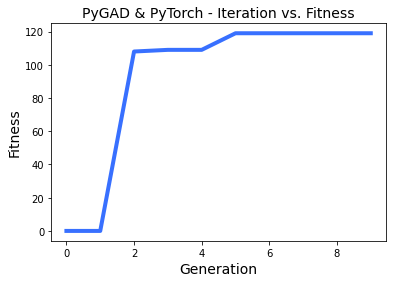

Generation = 11
Fitness    = 119
Generation = 12
Fitness    = 119
Generation = 13
Fitness    = 241
Generation = 14
Fitness    = 241
Generation = 15
Fitness    = 378
Generation = 16
Fitness    = 404
Generation = 17
Fitness    = 404
Generation = 18
Fitness    = 512
Generation = 19
Fitness    = 808
Generation = 20
MaxFitness    = 697


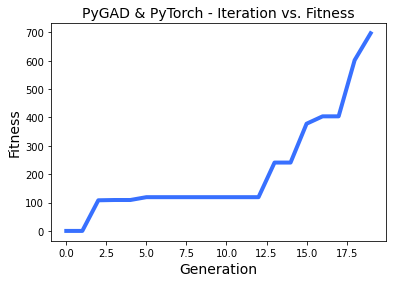

Generation = 21
Fitness    = 697
Generation = 22
Fitness    = 1278
Generation = 23
Fitness    = 1306
Generation = 24
Fitness    = 2013
Generation = 25
Fitness    = 2826
Generation = 26
Fitness    = 2826
Generation = 27
Fitness    = 3085
Generation = 28
Fitness    = 2826
Generation = 29
Fitness    = 2826
Generation = 30
MaxFitness    = 2826


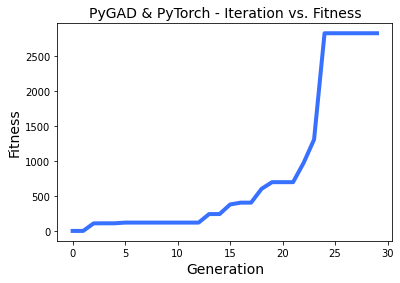

Generation = 31
Fitness    = 3189
Generation = 32
Fitness    = 3391
Generation = 33
Fitness    = 3977
Generation = 34
Fitness    = 3747
Generation = 35
Fitness    = 3905
Generation = 36
Fitness    = 3968
Generation = 37
Fitness    = 3941
Generation = 38
Fitness    = 4332
Generation = 39
Fitness    = 4422
Generation = 40
MaxFitness    = 4305


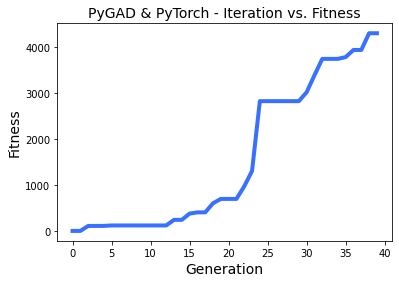

Generation = 41
Fitness    = 4305
Generation = 42
Fitness    = 4305
Generation = 43
Fitness    = 4305
Generation = 44
Fitness    = 4817
Generation = 45
Fitness    = 4681
Generation = 46
Fitness    = 4305
Generation = 47
Fitness    = 4305
Generation = 48
Fitness    = 4305
Generation = 49
Fitness    = 4305
Generation = 50
MaxFitness    = 4305


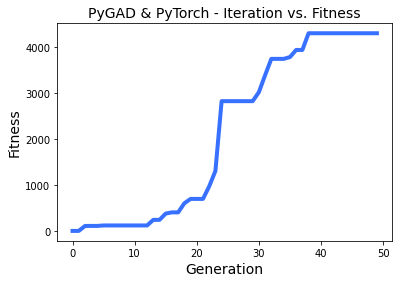

Generation = 51
Fitness    = 4305
Generation = 52
Fitness    = 4371
Generation = 53
Fitness    = 4305
Generation = 54
Fitness    = 4480
Generation = 55
Fitness    = 4652
Generation = 56
Fitness    = 4652
Generation = 57
Fitness    = 4672
Generation = 58
Fitness    = 4668
Generation = 59
Fitness    = 4668
Generation = 60
MaxFitness    = 4668


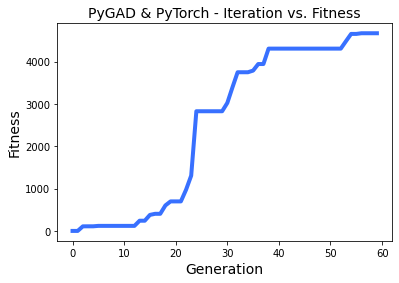

Generation = 61
Fitness    = 4974
Generation = 62
Fitness    = 5139
Generation = 63
Fitness    = 5139
Generation = 64
Fitness    = 5139
Generation = 65
Fitness    = 5139
Generation = 66
Fitness    = 5139
Generation = 67
Fitness    = 5139
Generation = 68
Fitness    = 5356
Generation = 69
Fitness    = 5327
Generation = 70
MaxFitness    = 5257


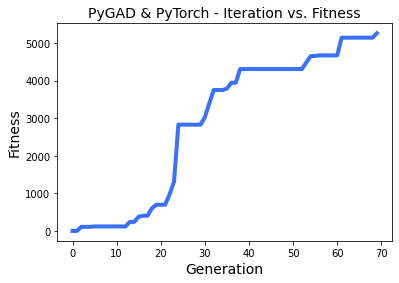

Generation = 71
Fitness    = 5319
Generation = 72
Fitness    = 6217
Generation = 73
Fitness    = 6759
Generation = 74
Fitness    = 6759
Generation = 75
Fitness    = 6759
Generation = 76
Fitness    = 6759
Generation = 77
Fitness    = 6759
Generation = 78
Fitness    = 6759
Generation = 79
Fitness    = 6759
Generation = 80
MaxFitness    = 6759


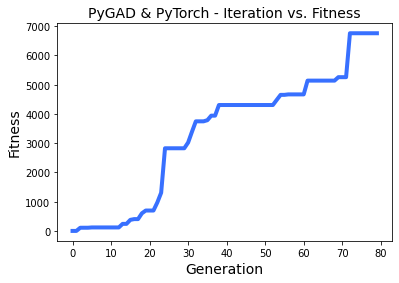

Generation = 81
Fitness    = 6759
Generation = 82
Fitness    = 6759
Generation = 83
Fitness    = 6759
Generation = 84
Fitness    = 6759
Generation = 85
Fitness    = 6759
Generation = 86
Fitness    = 6759
Generation = 87
Fitness    = 6759
Generation = 88
Fitness    = 6759
Generation = 89
Fitness    = 6759
Generation = 90
MaxFitness    = 6759


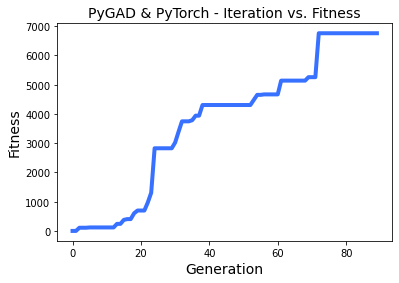

Generation = 91
Fitness    = 6759
Generation = 92
Fitness    = 6759
Generation = 93
Fitness    = 6759
Generation = 94
Fitness    = 6759
Generation = 95
Fitness    = 6759
Generation = 96
Fitness    = 6759
Generation = 97
Fitness    = 6759
Generation = 98
Fitness    = 6759
Generation = 99
Fitness    = 6759
Generation = 100
MaxFitness    = 6759


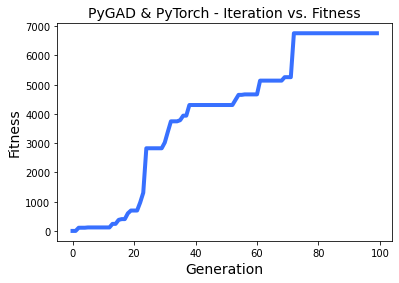

Generation = 101
Fitness    = 6759
Generation = 102
Fitness    = 6759
Generation = 103
Fitness    = 6759
Generation = 104
Fitness    = 6759
Generation = 105
Fitness    = 6759
Generation = 106
Fitness    = 6954
Generation = 107
Fitness    = 7379
Generation = 108
Fitness    = 7379
Generation = 109
Fitness    = 7379
Generation = 110
MaxFitness    = 7379


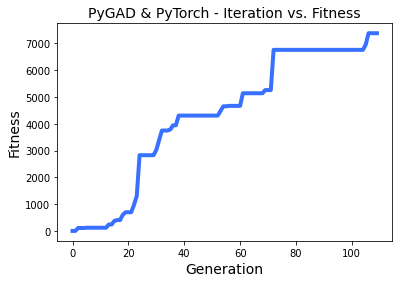

Generation = 111
Fitness    = 7379
Generation = 112
Fitness    = 7379
Generation = 113
Fitness    = 7379
Generation = 114
Fitness    = 7379
Generation = 115
Fitness    = 7379
Generation = 116
Fitness    = 7379
Generation = 117
Fitness    = 7379
Generation = 118
Fitness    = 7379
Generation = 119
Fitness    = 7396
Generation = 120
MaxFitness    = 7379


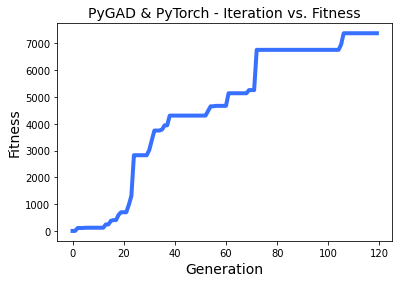

Generation = 121
Fitness    = 7379
Generation = 122
Fitness    = 7379
Generation = 123
Fitness    = 7379
Generation = 124
Fitness    = 7379
Generation = 125
Fitness    = 7379
Generation = 126
Fitness    = 7379
Generation = 127
Fitness    = 7379
Generation = 128
Fitness    = 7379
Generation = 129
Fitness    = 7379
Generation = 130
MaxFitness    = 7379


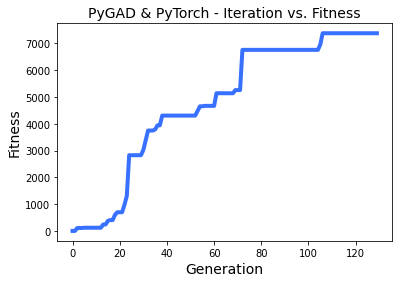

Generation = 131
Fitness    = 7842
Generation = 132
Fitness    = 7842
Generation = 133
Fitness    = 7842
Generation = 134
Fitness    = 7842
Generation = 135
Fitness    = 7842
Generation = 136
Fitness    = 7842
Generation = 137
Fitness    = 7842
Generation = 138
Fitness    = 7842
Generation = 139
Fitness    = 7842
Generation = 140
MaxFitness    = 7842


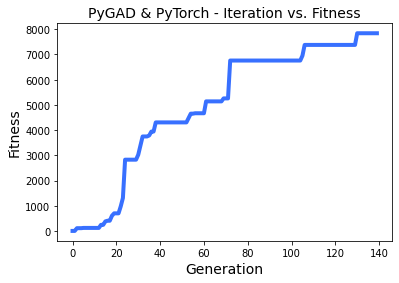

Generation = 141
Fitness    = 7842
Generation = 142
Fitness    = 7842
Generation = 143
Fitness    = 7842
Generation = 144
Fitness    = 7842
Generation = 145
Fitness    = 7842
Generation = 146
Fitness    = 7842
Generation = 147
Fitness    = 7842
Generation = 148
Fitness    = 7842
Generation = 149
Fitness    = 7842
Generation = 150
MaxFitness    = 7842


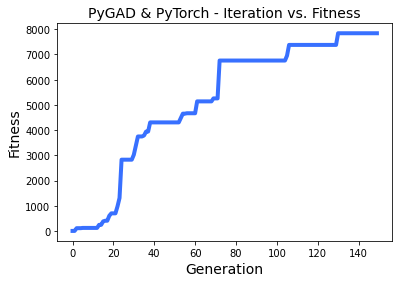

Generation = 151
Fitness    = 7842
Generation = 152
Fitness    = 7842
Generation = 153
Fitness    = 7842
Generation = 154
Fitness    = 7842
Generation = 155
Fitness    = 7842
Generation = 156
Fitness    = 7842
Generation = 157
Fitness    = 7842
Generation = 158
Fitness    = 7842
Generation = 159
Fitness    = 7842
Generation = 160
MaxFitness    = 7842


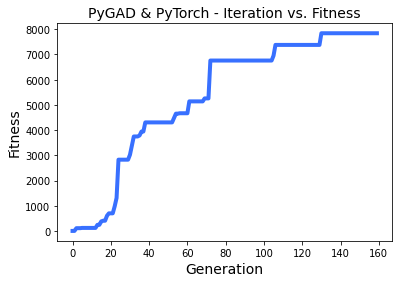

Generation = 161
Fitness    = 7842
Generation = 162
Fitness    = 7842
Generation = 163
Fitness    = 7842
Generation = 164
Fitness    = 7842
Generation = 165
Fitness    = 7842
Generation = 166
Fitness    = 7842
Generation = 167
Fitness    = 7842
Generation = 168
Fitness    = 7842
Generation = 169
Fitness    = 7842
Generation = 170
MaxFitness    = 7842


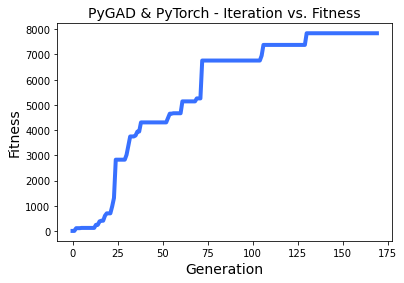

Generation = 171
Fitness    = 7842
Generation = 172
Fitness    = 7842
Generation = 173
Fitness    = 7842
Generation = 174
Fitness    = 7842
Generation = 175
Fitness    = 7842
Generation = 176
Fitness    = 7842
Generation = 177
Fitness    = 7842
Generation = 178
Fitness    = 7842
Generation = 179
Fitness    = 7842
Generation = 180
MaxFitness    = 7842


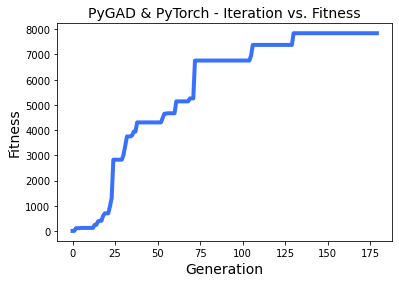

Generation = 181
Fitness    = 7842
Generation = 182
Fitness    = 7842
Generation = 183
Fitness    = 7842
Generation = 184
Fitness    = 7842
Generation = 185
Fitness    = 7842
Generation = 186
Fitness    = 7842
Generation = 187
Fitness    = 7842
Generation = 188
Fitness    = 7842
Generation = 189
Fitness    = 7842
Generation = 190
MaxFitness    = 7842


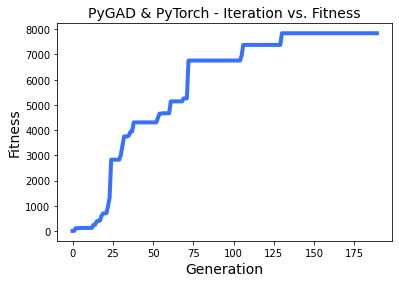

Generation = 191
Fitness    = 7842
Generation = 192
Fitness    = 7842
Generation = 193
Fitness    = 7842
Generation = 194
Fitness    = 7842
Generation = 195
Fitness    = 7842
Generation = 196
Fitness    = 7842
Generation = 197
Fitness    = 7842
Generation = 198
Fitness    = 7842
Generation = 199
Fitness    = 7842
Generation = 200
MaxFitness    = 7842


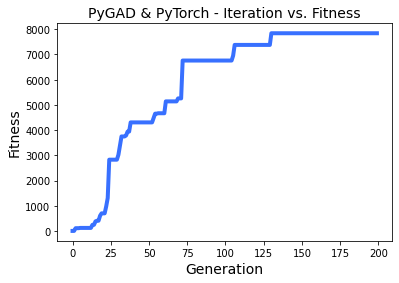

Generation = 201
Fitness    = 7842
Generation = 202
Fitness    = 7842
Generation = 203
Fitness    = 7842
Generation = 204
Fitness    = 7842
Generation = 205
Fitness    = 7842
Generation = 206
Fitness    = 7842
Generation = 207
Fitness    = 7842
Generation = 208
Fitness    = 7842
Generation = 209
Fitness    = 7842
Generation = 210
MaxFitness    = 8059


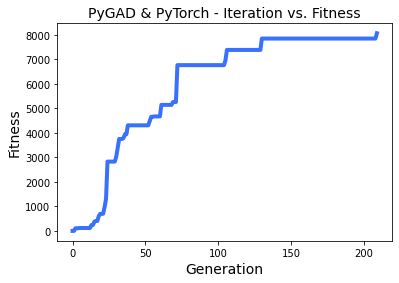

Generation = 211
Fitness    = 8059
Generation = 212
Fitness    = 8104
Generation = 213
Fitness    = 8226
Generation = 214
Fitness    = 8226
Generation = 215
Fitness    = 8226
Generation = 216
Fitness    = 8226
Generation = 217
Fitness    = 8226
Generation = 218
Fitness    = 8226
Generation = 219
Fitness    = 8226
Generation = 220
MaxFitness    = 8226


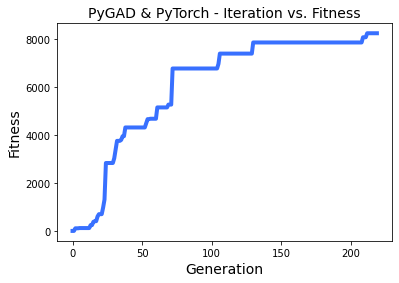

Generation = 221
Fitness    = 8226
Generation = 222
Fitness    = 8226
Generation = 223
Fitness    = 8247
Generation = 224
Fitness    = 8226
Generation = 225
Fitness    = 8226
Generation = 226
Fitness    = 8483
Generation = 227
Fitness    = 8235
Generation = 228
Fitness    = 8235
Generation = 229
Fitness    = 8811
Generation = 230
MaxFitness    = 8235


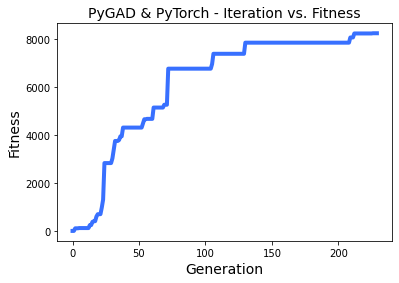

Generation = 231
Fitness    = 8319
Generation = 232
Fitness    = 8235
Generation = 233
Fitness    = 8235
Generation = 234
Fitness    = 8506
Generation = 235
Fitness    = 8506
Generation = 236
Fitness    = 8506
Generation = 237
Fitness    = 8506
Generation = 238
Fitness    = 8506
Generation = 239
Fitness    = 8506
Generation = 240
MaxFitness    = 8506


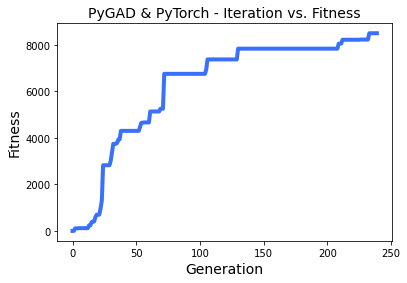

Generation = 241
Fitness    = 8506
Generation = 242
Fitness    = 8506
Generation = 243
Fitness    = 8506
Generation = 244
Fitness    = 8506
Generation = 245
Fitness    = 8506
Generation = 246
Fitness    = 8506
Generation = 247
Fitness    = 8506
Generation = 248
Fitness    = 8506
Generation = 249
Fitness    = 8506
Generation = 250
MaxFitness    = 8506


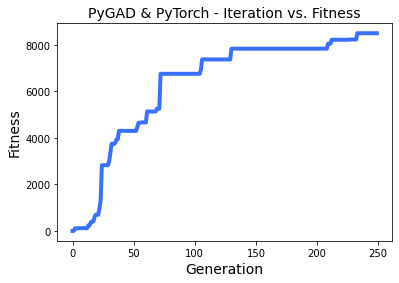

Generation = 251
Fitness    = 8506
Generation = 252
Fitness    = 8506
Generation = 253
Fitness    = 8506
Generation = 254
Fitness    = 8506
Generation = 255
Fitness    = 8506
Generation = 256
Fitness    = 8506
Generation = 257
Fitness    = 8506
Generation = 258
Fitness    = 8506
Generation = 259
Fitness    = 8506
Generation = 260
MaxFitness    = 8506


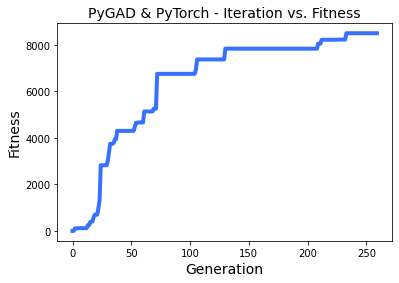

Generation = 261
Fitness    = 8506
Generation = 262
Fitness    = 8506
Generation = 263
Fitness    = 8506
Generation = 264
Fitness    = 8506
Generation = 265
Fitness    = 8506
Generation = 266
Fitness    = 8506
Generation = 267
Fitness    = 8506
Generation = 268
Fitness    = 8506
Generation = 269
Fitness    = 9119
Generation = 270
MaxFitness    = 8506


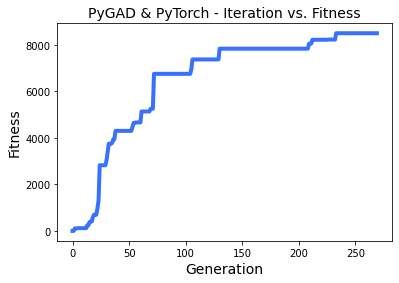

Generation = 271
Fitness    = 8506
Generation = 272
Fitness    = 8506
Generation = 273
Fitness    = 8506
Generation = 274
Fitness    = 8506
Generation = 275
Fitness    = 8506
Generation = 276
Fitness    = 8506
Generation = 277
Fitness    = 8506
Generation = 278
Fitness    = 8506
Generation = 279
Fitness    = 8861
Generation = 280
MaxFitness    = 8506


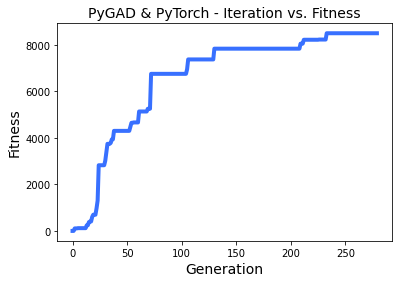

Generation = 281
Fitness    = 8506
Generation = 282
Fitness    = 8506
Generation = 283
Fitness    = 8506
Generation = 284
Fitness    = 8506
Generation = 285
Fitness    = 8760
Generation = 286
Fitness    = 8506
Generation = 287
Fitness    = 8787
Generation = 288
Fitness    = 8894
Generation = 289
Fitness    = 8894
Generation = 290
MaxFitness    = 8894


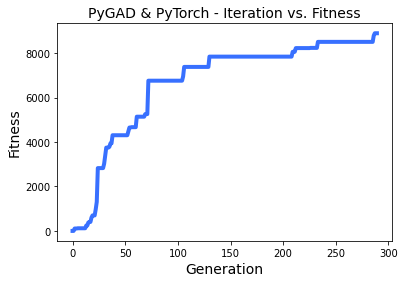

Generation = 291
Fitness    = 8894
Generation = 292
Fitness    = 8894
Generation = 293
Fitness    = 8894
Generation = 294
Fitness    = 8894
Generation = 295
Fitness    = 8894
Generation = 296
Fitness    = 8894
Generation = 297
Fitness    = 8894
Generation = 298
Fitness    = 8894
Generation = 299
Fitness    = 8894
Generation = 300
MaxFitness    = 8894


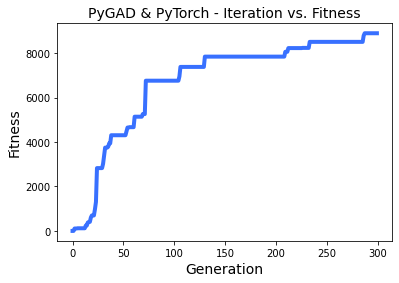

Generation = 301
Fitness    = 8894
Generation = 302
Fitness    = 8894
Generation = 303
Fitness    = 8894
Generation = 304
Fitness    = 8894
Generation = 305
Fitness    = 8894
Generation = 306
Fitness    = 9004
Generation = 307
Fitness    = 9004
Generation = 308
Fitness    = 9004
Generation = 309
Fitness    = 9004
Generation = 310
MaxFitness    = 9004


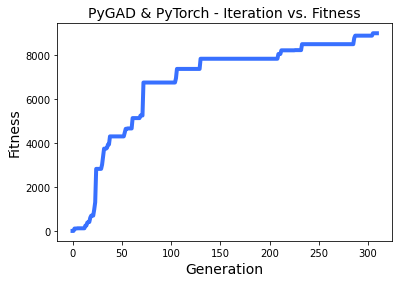

Generation = 311
Fitness    = 9220
Generation = 312
Fitness    = 9220
Generation = 313
Fitness    = 9220
Generation = 314
Fitness    = 9220
Generation = 315
Fitness    = 9220
Generation = 316
Fitness    = 9220
Generation = 317
Fitness    = 9220
Generation = 318
Fitness    = 9220
Generation = 319
Fitness    = 9220
Generation = 320
MaxFitness    = 9220


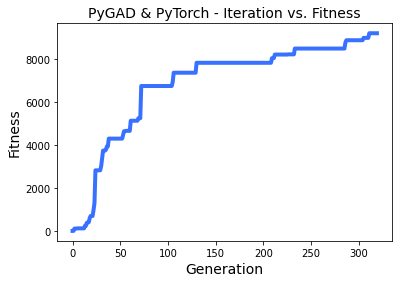

Generation = 321
Fitness    = 9220
Generation = 322
Fitness    = 9220
Generation = 323
Fitness    = 9220
Generation = 324
Fitness    = 9220
Generation = 325
Fitness    = 9220
Generation = 326
Fitness    = 9220
Generation = 327
Fitness    = 9220
Generation = 328
Fitness    = 9220
Generation = 329
Fitness    = 9220
Generation = 330
MaxFitness    = 9220


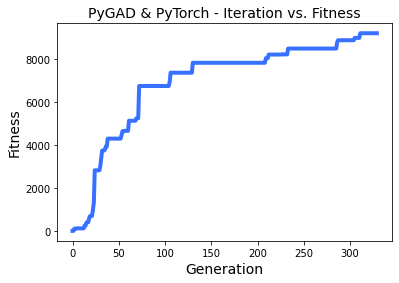

Generation = 331
Fitness    = 9220
Generation = 332
Fitness    = 9220
Generation = 333
Fitness    = 9220
Generation = 334
Fitness    = 9220
Generation = 335
Fitness    = 9220
Generation = 336
Fitness    = 9220
Generation = 337
Fitness    = 9220
Generation = 338
Fitness    = 9220
Generation = 339
Fitness    = 9220
Generation = 340
MaxFitness    = 9220


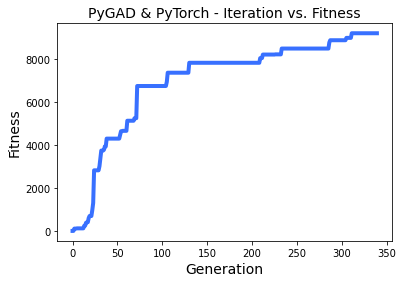

In [17]:
# тренировка
#----------------------------------------------------------------------------------------------------------#
if __name__ == "__main__":
    # делаем экземпляр доски
    b = Board(ROW, COL)
    # запускаем игру, передаем доску
    game_statistics_GA(b)
  
############################################################################################################
